In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')

In [2]:
import sys
sys.path.append('../code')
from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
tf.test.is_gpu_available()

False

## Load data

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_test = np.reshape(x_test,(x_test.shape[0],-1))

In [5]:
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

In [6]:
minibatch_size = 1000
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(10000)
#test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [7]:
N = x_train.shape[0]
D = x_train.shape[1]

## Define SVGP and DGP model

In [8]:
from scipy.stats import mode
from scipy.cluster.vq import kmeans2

In [9]:
# number of inducing points
M = 100
Z = kmeans2(x_train,M,minit='points')[0]

In [10]:
invlink = gpflow.likelihoods.RobustMax(10)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(10, invlink=invlink)  # Multiclass likelihood
kernel = gpflow.kernels.SquaredExponential()

m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, num_latent=10, whiten=True, q_diag=True)

In [11]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = gpflow.kernels.SquaredExponential()
        kernels.append(k)
        
    m_dgp = DGP(x_train, y_train, Z, (784, 30, 10), kernels, likelihood,
                white=True, num_samples=1, num_data=N, minibatch_size=minibatch_size)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
        
    return m_dgp

In [12]:
dgp = make_DGP(2)

In [13]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,1.0
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
SVGP.inducing_variable.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,,True,"(100, 10)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,True,"(100, 10)",float64,"[[1., 1., 1...."


In [14]:
gpflow.utilities.print_summary(dgp, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.likelihood.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,1.0
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,1.0
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[3.03878051e-19, -7.55026968e-20, 5.75681528e-19..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 10)",float64,"[[0., 0., 0...."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(10, 100, 100)",float64,"[[[1., 0., 0...."


## Training : minimizing ELBO

In [15]:
from tqdm import tqdm_notebook as tqdm

In [18]:
@tf.function(autograph=False)
def optimization_step(optimizer, model:gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

@tf.function(autograph=False)
def optimization_step_dgp(optimizer, model:dgp, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch, full_cov=False)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in range(iterations):
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf

def run_adam_dgp(model, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in tqdm(range(iterations)):
        elbo = - optimization_step_dgp(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
-8195.135717501042
-2225.3925711937236
-2039.618660661018
-1966.4789163258902
-2104.82113431546


Text(0.5, 1.0, 'ELBO of single layer SVGP')

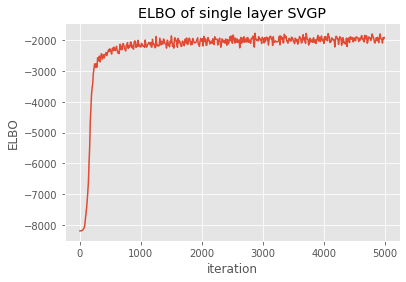

In [17]:
maxiter = ci_niter(5000)
logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-524746.9194451229
-36850.1812127743
-29952.477928439224
-25047.516353317384
-28637.12807709907



Text(0.5, 1.0, 'ELBO of DGP')

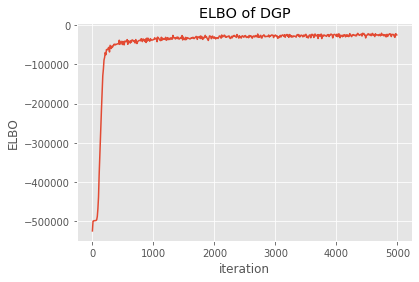

In [19]:
maxiter = ci_niter(5000)
logf_dgp = run_adam_dgp(dgp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP')

## Test Accuracy
SVGP: simply take the max mean prediction
DGP: We need a single prediction for each datum, so to do this we take $S$ samples for the one-hot predictions ($(S, N, 10)$ matrices for mean and var), then we take the max over the class means (to give a $(S, N)$ matrix), and finally we take the modal class over the samples (to give a vector of length $N$):

In [20]:
def assess_model_sgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    l = model.predict_log_density([X_batch, Y_batch])
    a = (np.argmax(m, 1).reshape(Y_batch.shape).astype(int)==Y_batch.astype(int))
    return l, a

S = 100
def assess_model_dgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    l = model.predict_density(X_batch, Y_batch, S)
    a = (mode(np.argmax(m, 2), 0)[0].reshape(Y_batch.shape).astype(int)==Y_batch.astype(int))
    return l, a

In [21]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(len(X)/1000), 1)
    lik, acc = [], []
    for X_batch, Y_batch in zip(np.split(X, n_batches), np.split(Y, n_batches)):
        l, a = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        acc.append(a)
    lik = np.concatenate(lik, 0)
    acc = np.array(np.concatenate(acc, 0), dtype=float)
    return np.average(lik), np.average(acc)

In [23]:
l, a = batch_assess(dgp, assess_model_dgp, x_test, y_test)
print('dgp2 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp2 test lik: -0.0793, test acc 0.9778


In [22]:
l, a = batch_assess(m, assess_model_sgp, x_test, y_test)
print('sgp test lik: {:.4f}, test acc {:.4f}'.format(l, a))

sgp test lik: -0.2807, test acc 0.9226
